In [93]:
import numpy
import pandas as pd
import nltk
import re
import io
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
#titles = io.open("titles.txt", mode="r", encoding="utf-8", errors="ignore").read().split('\n')
docs = io.open("../data/linalg_text2.txt", mode="r", encoding="utf-8", errors="ignore").read()
docs = re.sub(r"\[\d+\]", "", docs)
docs = re.sub(r'\w*\d\w*', '', docs).split('\n')
titles = [docs[i] for i in range(len(docs)) if i % 2 == 0]
docs = [docs[i] for i in range(len(docs)) if i % 2 == 1]


print(str(len(titles)) + ' titles')
print(str(len(docs)) + ' docs')
print(titles[-1])
print(docs[-1])

ranks = []

for i in range(0,len(titles)):
    ranks.append(i)
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

122 titles
122 docs
Linear equation
b'If n =  the set of the solutions is a plane in a three-dimensional space. More generally, the set of the solutions is an (n\\\\\\\)-dimensional hyperplane in a n-dimensional Euclidean space (or affine space if the coefficients are complex numbers or belong to any field).'b'In other words, if ai \\\ , one may choose arbitrary values for all the unknowns except xi, and express xi in term of these values.'b'If at least one coefficient is nonzero, a permutation of the subscripts allows one to suppose  \\\ , and rewrite the equation'b'If all the coefficients are zero, then either b \\\  and the equation does not have any solution, or b =  and every set of values for the unknowns is a solution.'b'where, , , ..., an represent numbers, called the coefficients, , , ..., xn are the unknowns, and b is called the constant term. When dealing with three or fewer variables, it is common to use x, y and z instead of ,  and .'b'A linear equation can involve more th

In [3]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

totalvocab_stemmed = []
totalvocab_tokenized = []
for i in docs:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [4]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words= stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(docs)

print(tfidf_matrix.shape)

Wall time: 8.81 s
(122, 1231)


In [6]:
terms = tfidf_vectorizer.get_feature_names()
print(terms)

["'b", "'b b", "'b b b'in", "'s", "'s formula", "'s rule", "'s theorem", '-dimension', '\\xce\\', '\\xce\\ \\xce\\', '\\xce\\xbb', '\\xcf\\', 'a.', 'a\\\\\\', 'ab', 'abelian', 'abl', 'abov', 'absolut', 'absolut valu', 'abstract', 'abstract algebra', 'accept', 'accord', 'account', 'accur', 'achiev', 'act', 'action', 'actual', 'ad', 'add', 'addit', 'addit multipl', 'addit scalar', 'addit scalar multipl', 'admit', 'advanc', 'advantag', 'affin', 'age', 'agre', 'ai', 'algebra', 'algebra close', 'algebra geometri', 'algebra structur', 'algorithm', 'allow', 'allow one', 'almost', 'along', 'alreadi', 'also call', 'also known', 'also use', 'altern', 'although', 'alway', 'among', 'amount', 'analog', 'analysi', 'analyt', 'analyt geometri', 'ancient', 'angl', 'ani', 'ani field', 'ani given', 'ani two', 'ani vector', 'anoth', 'answer', 'appear', 'appli', 'applic', 'approach', 'appropri', 'approxim', 'arbitrari', 'area', 'argument', 'aris', 'arithmet', 'around', 'arriv', 'art', 'articl', 'aspect', '

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [8]:
from sklearn.cluster import KMeans

num_clusters = 7

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 1.11 s


In [9]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [32]:
results = { 'origin_title': titles, 'rank': ranks, 'docs': docs, 'cluster': clusters}

frame = pd.DataFrame(results, index = [clusters] , columns = ['rank', 'origin_title', 'cluster'])

In [33]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['origin_title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: geometry, algebra, variety, algebra, geometric, topology,

Cluster 0 titles: Algebraic geometry, Geometry,

Cluster 1 words: kernel, matrix, vector, rows, spaces, v,

Cluster 1 titles: Kernel (linear algebra), Kernel (linear algebra), Kernel (linear algebra),

Cluster 2 words: equations, mathematical, function, spaces, set, systems,

Cluster 2 titles: System of polynomial equations, Representation theory, Functional analysis, Mathematical analysis, Lp space, Algebra over a field, Multilinear algebra, Module (mathematics), Field (mathematics), Free module, Cramer's rule, System of linear equations, Homogeneous coordinates, Linear equation, Partial differential equation, Dirichlet conditions, Fourier series, Linear least squares (mathematics), Normal matrix, Hermitian adjoint, CauchySchwarz inequality, Axiom, Polynomial, Algebraically closed field, Complex number, Invariant (mathematics), Eigenvalues and eigenvectors, Eigenvalues and eigenvectors,

In [34]:
frame.head()
#frame.loc[frame['cluster'] == 1].head()

,rank,origin_title,cluster
4,0,Linear algebra,4
0,1,Algebraic geometry,0
2,2,System of polynomial equations,2
2,3,Representation theory,2
2,4,Functional analysis,2


In [45]:
df = pd.read_csv('../data/linalg_links2.csv', encoding='latin1', header=0)
for i in df.columns:
    df[i] = df[i].apply(lambda x: x[2:-1])
df = df.merge(frame, on='origin_title')
df.head()

,origin_link,outgoing_link,origin_title,outgoing_title,rank,cluster
0,https://en.wikipedia.org/wiki/Linear_algebra,/wiki/Algebraic_geometry,Linear algebra,Algebraic geometry,0,4
1,https://en.wikipedia.org/wiki/Linear_algebra,/wiki/Systems_of_polynomial_equations,Linear algebra,Systems of polynomial equations,0,4
2,https://en.wikipedia.org/wiki/Linear_algebra,/wiki/Representation_theory,Linear algebra,Representation theory,0,4
3,https://en.wikipedia.org/wiki/Linear_algebra,/wiki/Functional_analysis,Linear algebra,Functional analysis,0,4
4,https://en.wikipedia.org/wiki/Linear_algebra,/wiki/Mathematical_analysis,Linear algebra,Mathematical analysis,0,4


In [51]:
df.loc[df['cluster'] == 1].head()

,origin_link,outgoing_link,origin_title,outgoing_title,rank,cluster
11842,https://en.wikipedia.org/wiki/Nullspace,/wiki/Lapack,Kernel (linear algebra),Lapack,44,1
11843,https://en.wikipedia.org/wiki/Nullspace,/wiki/Lapack,Kernel (linear algebra),Lapack,62,1
11844,https://en.wikipedia.org/wiki/Nullspace,/wiki/Lapack,Kernel (linear algebra),Lapack,70,1
11845,https://en.wikipedia.org/wiki/Nullspace,/wiki/Wikipedia:Citation_needed,Kernel (linear algebra),Wikipedia:Citation needed,44,1
11846,https://en.wikipedia.org/wiki/Nullspace,/wiki/Wikipedia:Citation_needed,Kernel (linear algebra),Wikipedia:Citation needed,62,1


In [87]:
def graph_cluster(n):
    G = nx.Graph()
    df_1 = df.loc[df['cluster'] == n]
    G.add_nodes_from(df_1['origin_title'])
    G.number_of_nodes()
    G.add_edges_from(tuple(x) for x in df_1[['origin_title', 'outgoing_title']].values)
    G.number_of_edges()
    return G

In [88]:
pr = nx.pagerank(graph_cluster(0))
df_pr = pd.DataFrame(list(pr.items()), columns=['page', 'rank'])
df_pr.sort_values('rank', ascending=False).head()

,page,rank
1,Geometry,0.249227
0,Algebraic geometry,0.211643
67,Analytic geometry,0.002080
87,Mathematics in medieval Islam,0.002080
84,Archimedes,0.002080


drawing cluster 0


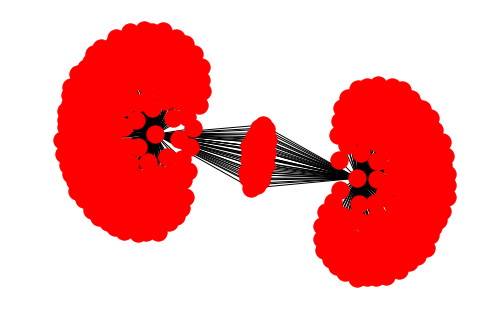

drawing cluster 1


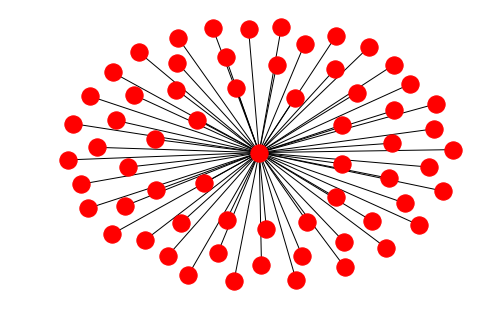

drawing cluster 2


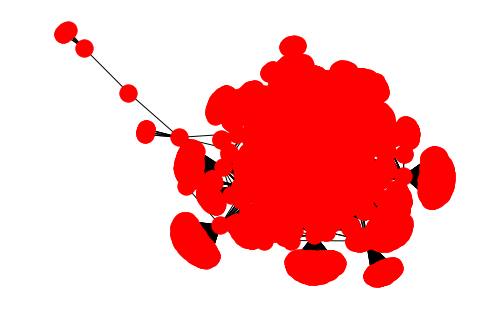

drawing cluster 3


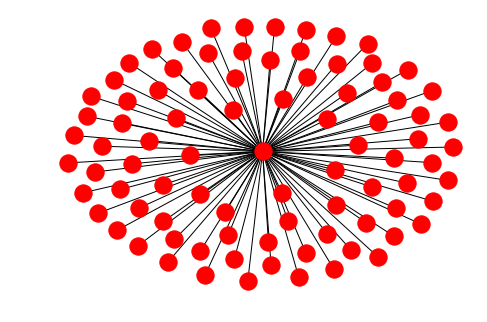

drawing cluster 4


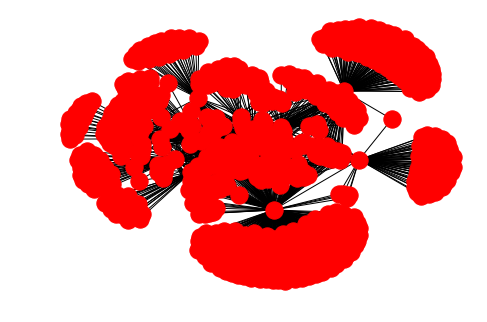

drawing cluster 5


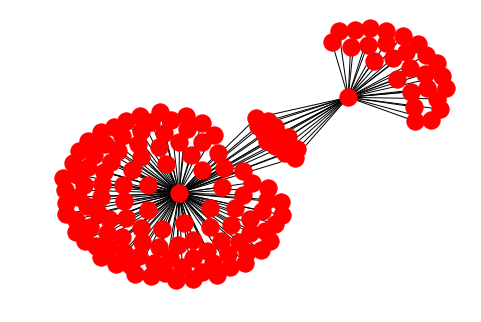

drawing cluster 6


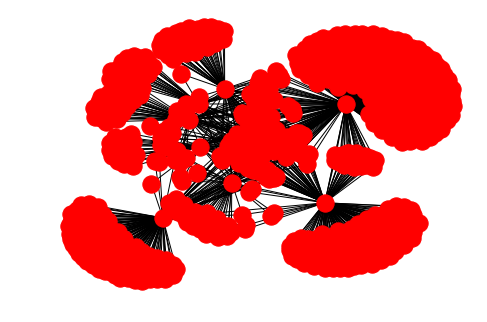

In [96]:
%matplotlib inline
for i in range(0,7):
    G = graph_cluster(i)
    print("drawing cluster %s" %i)
    plt.figure(i)
    nx.draw(G)
    plt.show()